In [41]:
import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.core import Flatten, Dense, Dropout, Reshape
from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.datasets import mnist

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Utils

In [9]:
def plotHistory(loss):
    plt.plot(loss)
    plt.title('loss through training')
    plt.ylabel('loss')
    plt.xlabel('batch')

# Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float16') / 255.
x_test = x_test.astype('float16') / 255.

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

print("training data: {}".format(x_train.shape))
print("testing data: {}".format(x_test.shape))

11493376/11490434 [==============================] - 4s 0us/step
training data: (60000, 28, 28, 1)
testing data: (10000, 28, 28, 1)


# Network

In [94]:
model = Sequential([
    Convolution2D(16, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1,)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.2),
    
    Convolution2D(16, kernel_size=5, padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.2),
    
    Flatten(),
    Dense(10, activation="softmax"),
])
encoder = Sequential([
    Convolution2D(8, kernel_size=3, padding="same", activation="relu", input_shape=(28, 28, 1,)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.2),
    Convolution2D(4, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Convolution2D(4, kernel_size=3, padding="same", activation="relu"),
    
    Flatten(),
    Dense(10, activation="softmax"),
])
decoder = Sequential([
    Dense(196, activation="relu", input_shape=(10,)),
    Reshape((7, 7, 4)),
    
    UpSampling2D(size=2),
    Convolution2D(8, kernel_size=3, padding="same", activation="relu"),
    UpSampling2D(size=2),
    Convolution2D(1, kernel_size=3, padding="same", activation="relu")
])

autoencoder = Sequential([
    encoder,
    decoder
])

autoencoder.summary()
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_32 (Sequential)   (None, 10)                2490      
_________________________________________________________________
sequential_33 (Sequential)   (None, 28, 28, 1)         2525      
Total params: 5,015
Trainable params: 5,015
Non-trainable params: 0
_________________________________________________________________


# Hyper Parameters

In [95]:
sgd = SGD(lr=0.01, momentum=0.9, decay=1e-6)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

autoencoder.compile(loss='mean_squared_error',
                   optimizer=sgd)

decoder.compile(loss='mean_squared_error',
                   optimizer=sgd)

# Training

In [96]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

In [97]:
history = LossHistory()
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=1, batch_size=128, callbacks=[history])
# autoencoder.fit(x_train, x_train, validation_data=(x_test, x_test), epochs=1, batch_size=128, callbacks=[history])
decoder.fit(y_train, x_train, validation_data=(y_test, x_test), epochs=3, batch_size=128, callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 22s 372us/step - loss: 0.0819 - val_loss: 0.0690
Epoch 2/3
60000/60000 [==============================] - 22s 366us/step - loss: 0.0646 - val_loss: 0.0618
Epoch 3/3
60000/60000 [==============================] - 24s 400us/step - loss: 0.0601 - val_loss: 0.0586


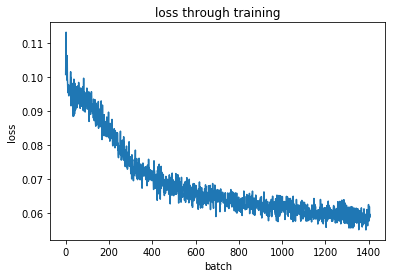

In [98]:
plotHistory(history.loss)

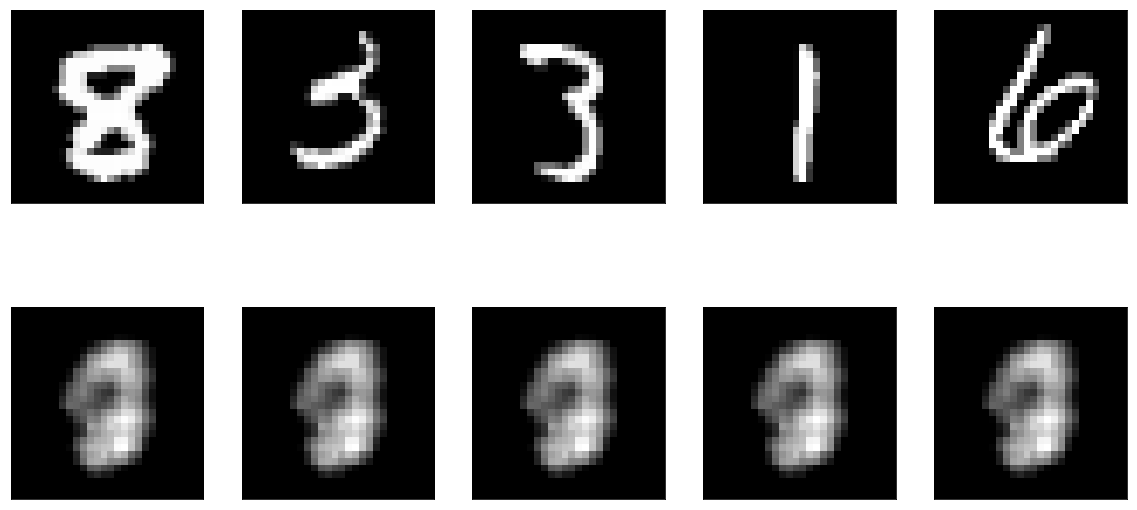

In [105]:
n_image = 5

display_index = np.random.choice(x_test.shape[0], n_image)
images = np.array([x_train[i] for i in display_index])
netout = autoencoder.predict(images)

plt.figure(figsize=(20, 10))

for i in range(n_image):
    ax = plt.subplot(2, n_image, i + 1)
    plt.imshow(images[i].reshape(28, 28).astype('float32'), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(2, n_image, n_image + i + 1)
    plt.imshow(netout[i].reshape(28, 28).astype('float32'), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)



# Test

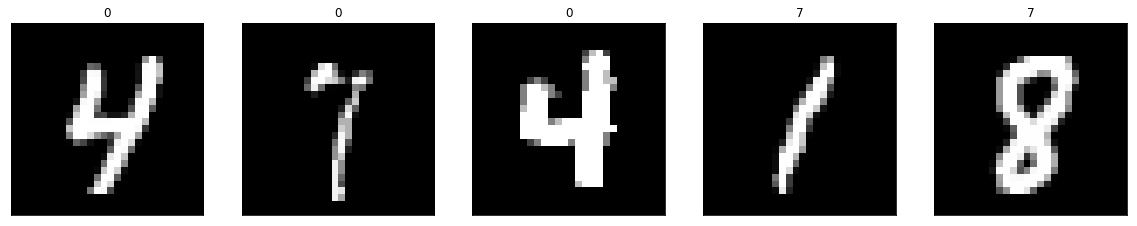

In [61]:
n_image = 5

display_index = np.random.choice(x_test.shape[0], n_image)
images = np.array([x_train[i] for i in display_index])
id_class = np.argmax(model.predict(images), axis=1)

plt.figure(figsize=(20, 4))

for i in range(n_image):
    ax = plt.subplot(1, n_image, i + 1)
    plt.imshow(images[i].reshape(28, 28).astype('float32'), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax.set_title("{0}".format(id_class[i]))
    